In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

## IMPORTING AND SORTING THE DATA

WE HAVE CHOSEN ICECUBE 2008-18 DATA FOR THIS STUDY


THE ICE CUBE DATA SET HAS 1134450 NEUTRINO EVENTS


We select neutrino events with Energy >= 100TeV = 10^5 GeV

i.e log10(E/GeV) > 5


There are 192107 such neutrino events in this data

The ms pulsars are taken from the ATNF Catalogue

There are 441 pulsars (as of May 2022 when the study started)

All the pulsars lie in the declination range of -87 to +87 degrees

In [2]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]

#icdata = icdata.sort_values('log10(E/GeV)')
#icdata = icdata.reset_index()
#icdata = icdata.drop('index', axis=1)
icdata2 = icdata[icdata['log10(E/GeV)'] > 5]
icdata2 = icdata2.reset_index()
icdata2 = icdata2.drop('index', axis=1)
icdata2

#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/10milsecpsr.txt", 'r')
lines = f.readlines()

content=[]
column=lines[3].split()
for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
mspdata = pd.DataFrame(content).drop(range(0,6)).dropna().drop([2,6,8,10,11,13,14], axis=1)
f.close()
line = []
lines = []

mspdata.columns = column
column = []
content=[]
mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
mspdata = mspdata.reset_index()
mspdata = mspdata.drop(["index", "#"], axis=1)

In [3]:
icdata2

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,54562.38662244,5.17,0.62,75.024,-13.371,349.100,76.646
1,54562.39267689,5.57,1.13,305.857,-33.932,120.413,56.090
2,54562.40477593,5.80,1.11,143.516,-38.279,287.171,51.684
3,54562.42794822,5.73,0.53,310.767,-25.374,128.245,64.650
4,54562.43975209,5.38,0.64,147.017,-22.059,296.282,67.903
...,...,...,...,...,...,...,...
192102,58307.86622128,5.05,0.31,283.724,-29.301,44.569,60.727
192103,58307.87487966,5.04,0.24,301.335,-69.169,29.895,20.890
192104,58307.88476760,5.09,0.36,6.179,-68.551,328.904,21.560
192105,58307.92028692,5.23,0.66,17.387,-34.366,330.510,55.740


In [4]:
mspdata

,NAME,Gl,Gb,RAJD,DECJD,P0,F0,DIST
0,J1853-0008g,33.014,-0.453,283.30,-0.13,0.00282,354.609929,4.554
1,J1625-0021,13.890,31.827,246.2931579,-0.358044,0.0028336138772234,352.90623328676,0.951
2,J1852-0044g,32.395,-0.560,283.11,-0.73,0.00241,414.937759,4.492
3,J1835-0114,29.990,3.007,278.841325,-1.242669,0.005116387644239,195.4503977286,3.452
4,J1901-0125,32.817,-2.902,285.39083,-1.42472,0.00279,358.422939,2.360
...,...,...,...,...,...,...,...,...
436,J1944+0907,47.160,-7.357,296.03887491,9.12306353,0.005185201908798642,192.8565208431179,1.218
437,J0023+0923,111.383,-52.849,5.82032291,9.38996121,0.003050203104754390,327.8470205611185,1.818
438,B1855+09,42.290,3.060,284.401626217,9.721442158,0.005362100549682627,186.4940783438289,1.200
439,J2234+0944,76.280,-40.438,338.69522573,9.74172845,0.003627027895734199,275.7078326240928,1.587


In [5]:
#icdata2 = nu_10gev(import_icdata())
#mspdata = import_psrdata()
msra = [float(i) for i in mspdata['RAJD']]
msdec = [float(i) for i in mspdata['DECJD']]
icra = [float(i) for i in icdata2['RA[deg]']]
icdec = [float(i) for i in icdata2['Dec[deg]']]
icang = [float(i) for i in icdata2['AngErr[deg]']]
p = len(msra)
lg = len(icra) // p + 1

In [6]:
def hvovec(lon1, lat1, lon2, lat2):

    #Convert decimal degrees to Radians:
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)

    a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))

    return np.abs(np.rad2deg(np.arccos(a)))

In [7]:
def angfinder(b):
    ang = []
    for a in range(lg):
        
        if a != lg - 1:
        #try:
            ilo = icra[a*p:a*p + p]
            ila = icdec[a*p:a*p + p]
            lo = msra[b] * np.ones(p)
            la = msdec[b] * np.ones(p)
            temp = hvovec(ilo, ila, lo, la)
            for tt in range(len(temp)):
                if temp[tt] > 20:
                    temp[tt] = -1
            ang.extend(temp)
        else:
        #except:
            ilo = icra[a*p:]
            ila = icdec[a*p:]
            ext = len(ilo)
            lo = msra[b] * np.ones(ext)
            la = msdec[b] * np.ones(ext)
            temp = hvovec(ilo, ila, lo, la)
            #ang.extend(hvovec(ilo, ila, lo, la))
            for tt in range(len(temp)):
                if temp[tt] > 20:
                    temp[tt] = -1
            ang.extend(temp)
            
        
    return ang

pool = mul.Pool()
op_async = pool.map_async(angfinder, range(0,p))
aang = op_async.get()
op_async = []
pool = []

In [8]:

#S_ij for ith neutrino and jth pulsar IS WRONG
#EDIT 04102022 - 11.28 - S_ij is for i^th pulsar and j^th neutrino and summed over all NEUTRINOS IS WRONG
#EDIT 06102022 - 16.52 - Si is for i^th neutrino and s^th pulsar as in \theta_s
def S_ij(i):### $P_i[a] = \dfrac{ns[a]}{N} S[a] + \left(1 - \dfrac{ns[a]}{N}\right)B[a]$ if ns 
                                                 #OR
    arr = []
    for j in range(0,len(icdata2)):
        
        ang = aang[i][j]
        if ang != -1:
            if ang < 20:
                sg = np.deg2rad(icang[j]) ** 2
                ang = np.deg2rad(ang) ** 2
                arr.append(np.exp(-1 * ang / (2 * sg)) / (2 * np.pi * sg))
        #return
        #else:
            #arr.append(0)
        #return -1
    
    return arr

In [9]:
def sij():
    pool = mul.Pool()
    op_async = pool.map_async(S_ij, range(0,p))
    si = op_async.get()
    pool = []
    op_async = []
    return si
S = sij()

In [10]:
len(S[0])

1257

In [11]:
#N != len(icdata2)
Ns = []
for i in aang:
    count = 0
    for j in i:
        if j != -1:
            count += 1
    Ns.append(count)
Ns = np.array(Ns)
    

In [12]:
lt = 6
def bg(i):
    #Calculating total no of neutrino events within delta +/- 6 of ith PULSAR (not neutrino)
    count = 0
    
    '''for j in icdec:
        if abs(msdec[i] - j) <= 6:
            count+=1 '''
    count = np.count_nonzero(np.abs(np.subtract(msdec[i],icdec))<lt)
    #calculating solid angle with 3deg
    num = (np.pi * np.deg2rad(lt))**2
    sang = 2 * np.pi * (np.sin(np.deg2rad(msdec[i] + lt)) - np.sin(np.deg2rad(msdec[i] - lt)))
    return num * count/sang

def Bi():
    pool = mul.Pool()
    op_async = pool.map_async(bg, range(0,p))
    return op_async.get()

B = np.array(Bi())

In [13]:
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))

In [14]:
TS = lambda i, x: 2*np.sum((np.log(Pr(x,  Ns[i], S[i], B[i])/B[i])))

In [15]:
TS(57,0)

0.0

In [16]:
def TSmax(i):
    #returns the TSmax for i^th GRB
    a = []
    for j in range(1000):
        a.append(TS(i,j))
         
    init_guess = a.index(max(a))
    nll = lambda x: -TS(i,x)
    soln = minimize(nll, init_guess ,bounds=((0,None),))
    ns = float(soln.x)
    return ns


In [17]:
pool = mul.Pool()
op_async = pool.map_async(TSmax, range(0,p))
ns = op_async.get()
op_async = []
pool = []
##   ns.append(TSmax(i))

/tmp/ipykernel_31310/3488755315.py:1: RuntimeWarning: divide by zero encountered in log
  TS = lambda i, x: 2*np.sum((np.log(Pr(x,  Ns[i], S[i], B[i])/B[i])))
/tmp/ipykernel_31310/3488755315.py:1: RuntimeWarning: invalid value encountered in log
  TS = lambda i, x: 2*np.sum((np.log(Pr(x,  Ns[i], S[i], B[i])/B[i])))
/tmp/ipykernel_31310/3488755315.py:1: RuntimeWarning: divide by zero encountered in log
  TS = lambda i, x: 2*np.sum((np.log(Pr(x,  Ns[i], S[i], B[i])/B[i])))
/tmp/ipykernel_31310/3488755315.py:1: RuntimeWarning: invalid value encountered in log
  TS = lambda i, x: 2*np.sum((np.log(Pr(x,  Ns[i], S[i], B[i])/B[i])))
/tmp/ipykernel_31310/3488755315.py:1: RuntimeWarning: divide by zero encountered in log
  TS = lambda i, x: 2*np.sum((np.log(Pr(x,  Ns[i], S[i], B[i])/B[i])))
/tmp/ipykernel_31310/3488755315.py:1: RuntimeWarning: invalid value encountered in log
  TS = lambda i, x: 2*np.sum((np.log(Pr(x,  Ns[i], S[i], B[i])/B[i])))
/tmp/ipykernel_31310/3488755315.py:1: RuntimeWarn

In [18]:
len(ns)

441

In [19]:
tns = np.array([TS(i,ns[i]) for i in range(p)])

In [20]:
c = []
d = []
for i in ns:
    if i != 0:
        c.append(ns.index(i))
        d.append(TS(ns.index(i), i))
        print(TS(ns.index(i), i))

0.35139917428175427
0.275251921732771
0.016157131807011366
0.3606519702883445
2.6791595973559823
0.29487733451788983
3.8832005771623677
1.1761561748689988
3.1054941660491178
3.604683555541767
2.0949936770918027
0.24390659081002386


In [24]:
print("Pulsar\tns\tTSmax")
for i in range(len(c)):
    print(f"{c[i]}\t{ns[c[i]]}\t{d[i]}")

Pulsar	ns	TSmax
306	0.4952792297551354	0.35139917428175427
370	0.4388609945406392	0.275251921732771
378	0.14008974007140793	0.016157131807011366
381	0.5391081259241793	0.3606519702883445
394	1.246164084400945	2.6791595973559823
396	0.5293035192666727	0.29487733451788983
397	1.4314841756181307	3.8832005771623677
406	0.7819873903398157	1.1761561748689988
413	0.9261893908452634	3.1054941660491178
423	0.9437995012350532	3.604683555541767
428	0.8924087445950368	2.0949936770918027
429	0.5061658084404347	0.24390659081002386


In [25]:
TS(57, 45)

-90.0871884421903

/tmp/ipykernel_31310/3488755315.py:1: RuntimeWarning: divide by zero encountered in log
  TS = lambda i, x: 2*np.sum((np.log(Pr(x,  Ns[i], S[i], B[i])/B[i])))
/tmp/ipykernel_31310/3488755315.py:1: RuntimeWarning: invalid value encountered in log
  TS = lambda i, x: 2*np.sum((np.log(Pr(x,  Ns[i], S[i], B[i])/B[i])))


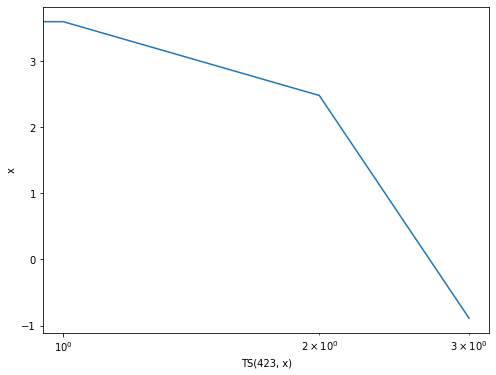

In [26]:
i = 423
n = np.array(range(0, 1000))
ts = [TS(i, x) for x in range(1000)]
plt.figure(figsize=(8,6))
plt.xscale('log')
plt.plot(n, ts)
plt.ylabel('x')
plt.xlabel(f'TS({i}, x)')
plt.savefig(f"TS({i}).jpg")
plt.show()
